# Modificar códigos de modelos de sklearn para su entrenamiento y predicción

El objetivo del Notebook es predecir un valor "target" y luego de acuerdo a esa predicción del valor target clasificarla en un rango de "alerta": [bajo, medio, alto] donde los intervalos para cada uno de estos rangos están definidos de acuerdo a la distribución del target.

Realizar la predicción y la posterior clasificación se puede hacer principalmente de dos formas: 
- dentro del código del modelo (modificándose las funciones de sklearn) 
- fuera como una función aparte

La ventaja de realizar la primera implementeción es que se puede obtener un solo "artefacto" que realiza ambas predicciones del cual el data scientist tiene completo completo y permite acoplar su modelo de forma simple con cualquier aplicación web. La forma para realizar la "predicción del valor" del target y su "predicción de alerta" es modificar los métodos de modelos de sklearn ya sean "fit, predict, transform" para que estos realizen una operación "EXTRA" a lo que realizan por defecto (en este caso clasificar la predicción en uno de los 3 rangos mencionados). 

Los ejemplos que se mostrarán son los siguientes:

1.- Realizar predicción con el artefacto del modelo y luego una función aparte para clasificar en uno de los 3 intervalos

2.- Modificar la clase del modelo para que el método "predict" retorne la predicción y además la clasificación en un intervalo

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### 1. Generar datos

In [2]:
#### generar datos ###

# parametros
len_data = 1000
number_columns = 6
data = []
list_variables = ["AA" , "BB", "CC", "DD" , "EE", "target"]


# seed - replicar resultados
np.random.seed(42)


# generar data aleatoria
for column in range(number_columns):
    random_choise = np.random.choice(10) + 1 # amplitud
    data_column = np.random.rand(len_data)
    data_column = random_choise * data_column
    data.append(data_column)
    
# a dataframe
data = pd.DataFrame(data).T
data.columns = list_variables

# serparar train y test
features = list(set(list_variables) - set(['target']))
X_train, X_test, y_train, y_test = train_test_split(data[features], data['target'], test_size = 0.2, random_state=42)

# generar instancia para ejemplo de una sola predicción
instance_X = X_test.iloc[[0], :]
instance_y = y_test.iloc[0]


#PRINT INFO
print('TRAIN')
print('X_train', X_train.shape)
print('y_train', y_train.shape)

print('\nTEST')
print('X_test', X_test.shape)
print('y_test', y_test.shape)

print('\nINSTANCIAS')
print('Instancia X\n', instance_X)
print('\nInstance y\n', instance_y)

TRAIN
X_train (800, 5)
y_train (800,)

TEST
X_test (200, 5)
y_test (200,)

INSTANCIAS
Instancia X
            CC        DD        EE        BB        AA
521  2.667259  1.030929  2.446586  1.330653  2.750926

Instance y
 3.194815109866423


<AxesSubplot:>

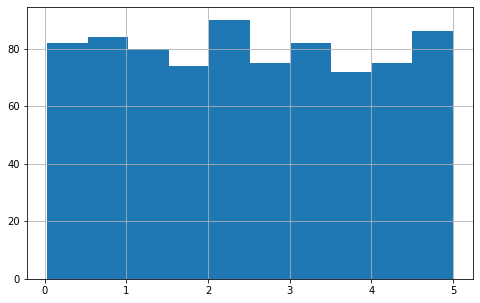

In [3]:
# histograma y train
y_train.hist(figsize = (8,5))

<AxesSubplot:>

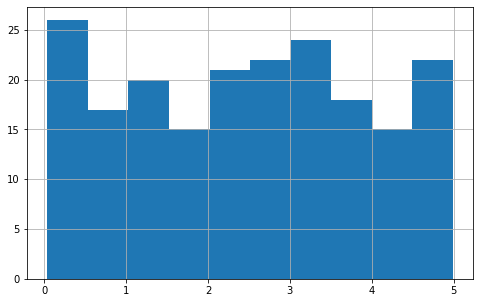

In [4]:
# histograma y test
y_test.hist(figsize = (8,5))

Se observa que el target se mueve entre [0,5]. Para este ejemplo se van a definir los intervalos de la forma (cerrados a la derecha, abiertos a la izquierda):
- Bajo: Valores entre 0 y 2.5. Intervalo: ]0, 2.5]

- Medio: Valores entre 2.5 y 4. Intervalo: ]2.5, 4]

- Alto: Valores entre 4 y 5. Intervalo: ]4, 5]

### 2. Modelo predecir valor. Función externa predecir intervalo
Para este ejemplo se va a utilizar una regresión lineal como modelo. Luego se va a crear una función que se encargará de clasificar la predicción en uno de los intervalos de alerta

In [5]:
def get_interval_alert(values):
    """
    Obtener intervalo a partir del valor.
    
    Args:
        value (array list): array de numpy con los valores a calcularles el rango. Formato: (shape, )
        
    Returns:
        array: array de strings con la clasificación de la alerta. Formato (shape, )
    """
    array_alerts = pd.cut(
        x = values,
        bins = [1, 2.5, 4, 5],
        labels = ['bajo', 'medio', 'alto']
    )
    array_alerts = np.array(array_alerts)
    
    return array_alerts

In [6]:
# crear modelo
model = LinearRegression()

# entrenar modelo
model.fit(X_train, y_train)

LinearRegression()

In [7]:
# ejemplo predecir una instancia

y_instance_predicted = model.predict(instance_X)
y_instance_alert = get_interval_alert(y_instance_predicted)

print('Ejemplo instancia')
print('predicción: ', y_instance_predicted)
print('alerta: ', y_instance_alert)

Ejemplo instancia
predicción:  [2.48152808]
alerta:  ['bajo']


In [8]:
# ejemplo predecir X_test
y_test_predicted = model.predict(X_test)
y_test_alert = get_interval_alert(y_test_predicted)

print('X_test shape')
# print('predicción: ', y_test_predicted)
# print('alerta: ', y_test_alert)
print('predicción: ', y_test_predicted.shape)
print('alerta: ', y_test_alert.shape)

X_test shape
predicción:  (200,)
alerta:  (200,)


### 3. Modificar método "predict". Retornar predicción y alerta
Para agregar la funcionalidad deseada al método predict de una clase modelo de scikit-learn se puede crear una nueva clase que herede la clase modelo (en el ejemplo crear una clase que herede la clase "LinearRegression") y sobrescribir el método predict.

IMPORTANTE:
En este ejemplo, se crea una nueva clase MyLinearRegression que hereda de LinearRegression. Luego, se sobreescribe el método predict de la clase base. La función super() llama al método predict de la clase base, que devuelve las predicciones en sí mismas. Además se crea un método auxiliar que recibe un valor "y" y retorna el intervalo de alerta dado dicho valor (el método auxiliar tiene que ser válido tanto para predecir una observación como múltiples observaciones)

In [9]:
from sklearn.linear_model import LinearRegression
class MyLinearRegression(LinearRegression):
    
    def get_interval_alert(self, y):
        """
        Método auxiliar. Obtener intervalo de alerta a partir del valor.

        Args:
            value (array list): array de numpy con los valores a calcularles el rango. Formato: (shape, )

        Returns:
            array: array de strings con la clasificación de la alerta. Formato (shape, )
        """
        alerts = pd.cut(
            x = y,
            bins = [1, 2.5, 4, 5],
            labels = ['bajo', 'medio', 'alto']
        )
        return np.array(alerts)

    
    def predict(self, X):
        
        # predecir con el método base .predict()
        y_pred = super().predict(X)
        
        # llamar método auxiliar para obtener rango
        y_alert = self.get_interval_alert(y_pred)
        
        return y_pred, y_alert

In [10]:
# crear modelo custom 
lr_alerts = MyLinearRegression()

# entrenar modelo
lr_alerts.fit(X_train, y_train)

MyLinearRegression()

In [11]:
# ejemplo predecir instancia
y_instance_predicted, y_alert_predicted = lr_alerts.predict(instance_X)

print('Ejemplo instancia')
print('predicción: ', y_instance_predicted)
print('alerta: ', y_instance_alert)

Ejemplo instancia
predicción:  [2.48152808]
alerta:  ['bajo']


In [12]:
# ejemplo predecir X_test
y_test_predicted, y_test_alert = lr_alerts.predict(X_test)

print('data test')
print('predicción: ', y_test_predicted)
print('alerta: ', y_test_alert)

data test
predicción:  [2.48152808 2.60478098 2.46720996 2.6889095  2.39454799 2.7181138
 2.38421206 2.60825112 2.42931986 2.38525177 2.38180426 2.74607523
 2.42967537 2.4053719  2.63168299 2.51204814 2.36840288 2.47450377
 2.40130412 2.34319053 2.60483131 2.41232976 2.63981062 2.55918844
 2.41953636 2.67085421 2.65311535 2.55972155 2.42422051 2.29061877
 2.49311766 2.48534342 2.49397943 2.52415196 2.57645459 2.49150753
 2.5518417  2.70132301 2.58676897 2.5376278  2.46350438 2.69568043
 2.48419916 2.38565707 2.54267595 2.56296613 2.44540773 2.63680075
 2.61017883 2.63002649 2.54459411 2.44971739 2.37147829 2.57965038
 2.59288299 2.48159023 2.38593837 2.69862897 2.71549908 2.4158476
 2.42577241 2.42492184 2.43824463 2.35866842 2.57446059 2.30147586
 2.49870578 2.43322746 2.25795785 2.57271241 2.50931512 2.44586082
 2.49366483 2.51085634 2.61179751 2.47163832 2.52834142 2.47352663
 2.32979487 2.53528946 2.383751   2.30258777 2.58597172 2.67463999
 2.68625969 2.40673123 2.52389546 2.38975

### 4. Modificar métodos "train" y "predict". 
Se realiza una nueva modificación al ejemplo del punto anterior, modificándose también el método "train" para realizar un entrenamiento custom de los modelos.

En el ejemplo anterior se modificó el método "predict" para realizar la predicción y la clasificación de la alerta de acuerdo a un rango "bajo" ]0, 2.5], "medio" ]2.5, 4] y "alto" ]4, 5] donde estos rangos están pre establecidos. En este ejemplo se realiza una modificación al método "train" para que los thresholds de los intervalos también se "entrenen" de acuerdo a la distribución de los datos de train.

El entrenamiento de los thresholds de los intervalos se realiza de forma simplificada en base a a percentiles. El thresold bajo-medio va a ser en el percentil 50, threshold medio-alto en el percentil 90. 

Este es un ejemplo simple, solo utilizado para mostrar cómo modificar las clases de los modelos de sckit-learn y tener modelos customizados

In [13]:
# parametro
y = y_train

In [14]:
y.describe(percentiles = [0.5, 0.9])

count    800.000000
mean       2.493488
std        1.444844
min        0.030919
50%        2.444215
90%        4.550246
max        4.996752
Name: target, dtype: float64

In [15]:
class lr_custom_alerts(LinearRegression):
    """
    Clase Regresión Lineal customizada que retorna la predicción y un grado de alerta
    """
    
    def train_custom_thresholds_alerts(self, y):
        '''
        Método auxiliar. "Entrenamiento" custom para obtener thresholds de alertas

        Args:
            y (array): valores y de entrenamiento para obtener thresholds

        Returns:
            None: No retorna nada. Guarda los valores obtenidos como parámetros de la clase
        '''
        # params
        percentil_bajo_medio = 0.5
        percentil_medio_alto = 0.9

        # ""train"" threshold
        self.min_value = np.round(y.min(), 2)
        self.max_value = np.round(y.max(), 2)
        self.threshold_1 = np.round(y.quantile(percentil_bajo_medio), 2)
        self.threshold_2 = np.round(y.quantile(percentil_medio_alto), 2)

    def get_interval_alert(self, y):
        """
        Método auxiliar. Obtener intervalo de alerta a partir del valor.

        Args:
            y (array list): array de numpy con los valores a calcularles el rango. Formato: (shape, )

        Returns:
            array: array de strings con la clasificación de la alerta. Formato (shape, )
        """
        alerts = pd.cut(
            x = y,
            bins = [self.min_value, self.threshold_1, self.threshold_2, self.max_value],
            labels = ['bajo', 'medio', 'alto']
        )
        return np.array(alerts)

    
    def fit(self, X, y):
        """
        Método train custom. Llamar al método train de la clase base y al método auxiliar para entrenar el intervalo de alerta
        """
        super().fit(X, y)
        self.train_custom_thresholds_alerts(y)
    
    
    def predict(self, X):
        """
        Método predict custom. Llama al método predict de la clase base y al método auxiliar para obtener el intervalo de alerta
        """
        y_pred = super().predict(X)
        y_alert = self.get_interval_alert(y_pred)
        
        return y_pred, y_alert

In [16]:
# crear modelo
lr_custom = lr_custom_alerts()

# entrenar 
lr_custom.fit(X_train, y_train)

In [17]:
# ver intervalos obtenidos del entrenamiento
print('threshold 1: ', lr_custom.threshold_1)
print('threshold 2: ', lr_custom.threshold_2)

threshold 1:  2.44
threshold 2:  4.55


In [18]:
# ejemplo predecir instancia
y_instance_predicted, y_alert_predicted = lr_custom.predict(instance_X)

print('Ejemplo instancia')
print('predicción: ', y_instance_predicted)
print('alerta: ', y_instance_alert)

Ejemplo instancia
predicción:  [2.48152808]
alerta:  ['bajo']


In [19]:
# ejemplo predecir X_test
y_test_predicted_, y_test_alert_ = lr_custom.predict(X_test)

print('data test')
print('predicción: ', y_test_predicted_.shape)
print('alerta: ', y_test_alert_.shape)

data test
predicción:  (200,)
alerta:  (200,)


### 5. Comparar diferencias
Comparar diferencia en predicciones entre modelo con threholds harcodeado (versión 1) y thresholds entrenados (versión 2)

In [20]:
comp = pd.DataFrame()
comp['pred_1'] = y_test_predicted
comp['pred_2'] = y_test_predicted_
comp['alerts_1'] = y_test_alert
comp['alerts_2'] = y_test_alert_

comp

,pred_1,pred_2,alerts_1,alerts_2
0,2.481528,2.481528,bajo,medio
1,2.604781,2.604781,medio,medio
2,2.467210,2.467210,bajo,medio
3,2.688910,2.688910,medio,medio
4,2.394548,2.394548,bajo,bajo
...,...,...,...,...
195,2.320641,2.320641,bajo,bajo
196,2.352918,2.352918,bajo,bajo
197,2.227477,2.227477,bajo,bajo
198,2.454153,2.454153,bajo,medio


### 6.1 Guardar artefacto modelo custom

In [21]:
import pandas as pd
from sklearn.linear_model import LinearRegression

In [22]:
# param model name
model_name = 'model.pkl'

In [23]:
# guardar pickle modelo
import pickle

with open(model_name, 'wb') as file:
    pickle.dump(lr_custom, file)

### 6.2 Leer artefacto modelo custom
Para leer un modelo custom de sklearn no basta con tener el pkl del modelo, ya que este pkl llama a la clase del modelo. Como en este caso la clase es custom se necesita tener un script con el código del modelo (donde este script debe contener todas las librerías que necesita y el código). Luego se debe hacer el import y listo

In [24]:
%%writefile lr_custom_alerts.py
### script con las librerías y la clase del modelo ###

from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

class lr_custom_alerts(LinearRegression):
    """
    Clase Regresión Lineal customizada que retorna la predicción y un grado de alerta
    """
    
    def train_custom_thresholds_alerts(self, y):
        '''
        Método auxiliar. "Entrenamiento" custom para obtener thresholds de alertas

        Args:
            y (array): valores y de entrenamiento para obtener thresholds

        Returns:
            None: No retorna nada. Guarda los valores obtenidos como parámetros de la clase
        '''
        # params
        percentil_bajo_medio = 0.5
        percentil_medio_alto = 0.9

        # ""train"" threshold
        self.min_value = np.round(y.min(), 2)
        self.max_value = np.round(y.max(), 2)
        self.threshold_1 = np.round(y.quantile(percentil_bajo_medio), 2)
        self.threshold_2 = np.round(y.quantile(percentil_medio_alto), 2)

    def get_interval_alert(self, y):
        """
        Método auxiliar. Obtener intervalo de alerta a partir del valor.

        Args:
            y (array list): array de numpy con los valores a calcularles el rango. Formato: (shape, )

        Returns:
            array: array de strings con la clasificación de la alerta. Formato (shape, )
        """
        alerts = pd.cut(
            x = y,
            bins = [self.min_value, self.threshold_1, self.threshold_2, self.max_value],
            labels = ['bajo', 'medio', 'alto']
        )
        return np.array(alerts)

    
    def fit(self, X, y):
        """
        Método train custom. Llamar al método train de la clase base y al método auxiliar para entrenar el intervalo de alerta
        """
        super().fit(X, y)
        self.train_custom_thresholds_alerts(y)
    
    
    def predict(self, X):
        """
        Método predict custom. Llama al método predict de la clase base y al método auxiliar para obtener el intervalo de alerta
        """
        y_pred = super().predict(X)
        y_alert = self.get_interval_alert(y_pred)
        
        return y_pred, y_alert

Writing lr_custom_alerts.py


In [25]:
from lr_custom_alerts import lr_custom_alerts

In [26]:
# param model name
model_name = 'model.pkl'

In [27]:
# read model
model_readed = pd.read_pickle(model_name)


# instance
instance_example = pd.DataFrame(
[
    [2.667259,  2.750926,  2.446586,  1.030929,  1.330653]
])

# predict
model_readed.predict(instance_example)

(array([2.46608924]), array(['medio'], dtype=object))